# Flight Dynamics Surrogate Model for High-Altitude Stall Upset
Author: Mohamad Hamza, Arizona State University 

Email: mhamza1@asu.edu

## Part 1: Surrogate  Model

This notebook shows a demonstration of using a surrogate model for high-altitude stall upset.

<img src="CLSTM_illustration.png">

## Code Requirements
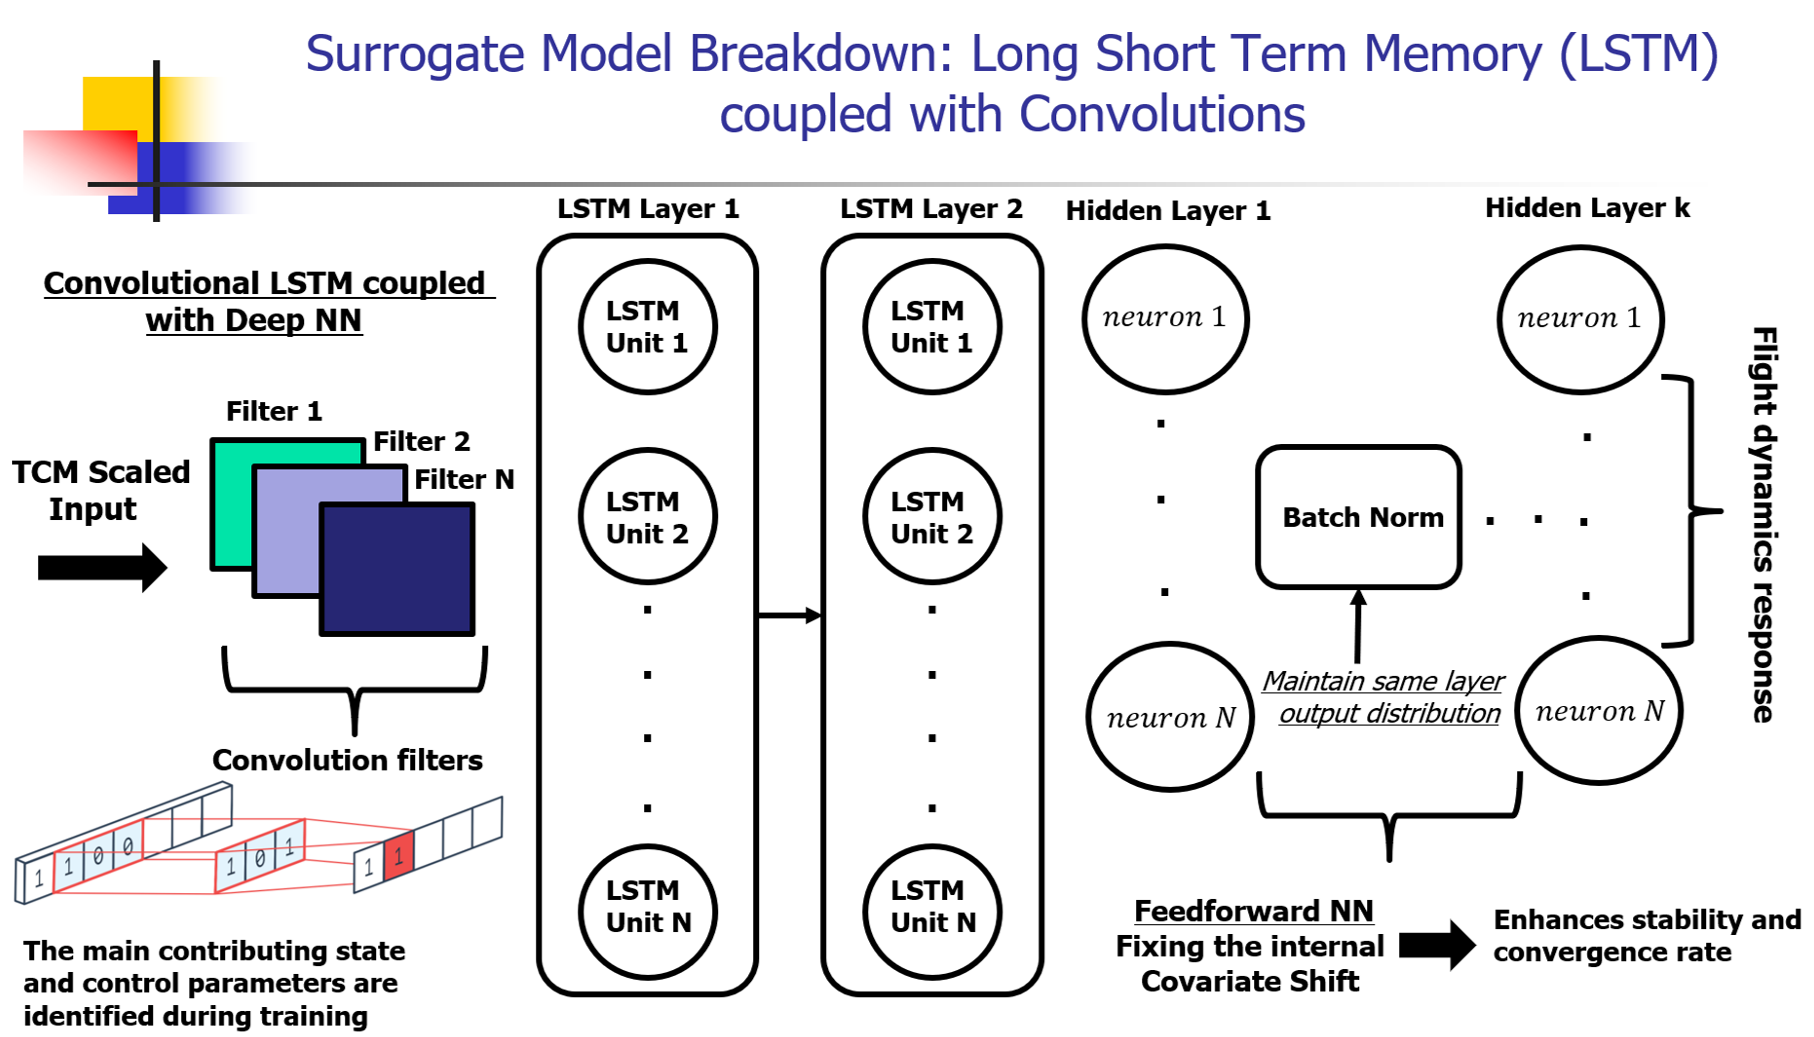

The Python packages required to run this module are:
- **[```tensorflow```]**
    - Tensorflow is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools and libraries.
    
- **[```keras```]**
    - A Python deep learning API.
 
This is in addition to ```numpy```, ```os```,```pandas```,  and ```matplotlib```.

## Data Requirements

A user of this code will need to access and download the training data from the Transport Class Model (TCM) simulations. That data can be found [here](https://1drv.ms/u/s!Aiwxve5lUeA1gqge3JPojtWFMMxhPA?e=DggKrW). The user will then need to store the data on their system and have the directory location assigned as the variable `DataDir` below. 

## Procedure 1: Setup of Machine Learning Surrogate
### Step 1.1 Input and Output Directories

In [65]:
DataDir = "Data"
outDir = "Results_ML"

### Step 1.2 Machine Learning Surrogate Model Setup
Firstly we determine if we want to use an existing model or train a new one with data in `DataDir`. For this demonstration, we want to use an existing model contained in the file `surrogateModel.h5`. As such, we set the variable `trainingMode` to 0 to indicate use of an existing model. If we want to train the surrogate with new data, we would set `trainingMode` to 1. Set the variable `surrogateName` to name either the training model or the loaded model.

Secondly, choose whether CPU or GPU will be used for either training or testing. Set the variable `GPU_ID` to -1 for CPU implementation and set it to 0 for the GPU implementation. Note if multiple GPUs exists on your node, then 0 will corresponds to the first GPU, 1 corresponds to second GPU, etc. 

In [66]:
trainingMode = 0 #if training model, it will be 1. if you just want to use an existing model, use 0. 
surrogateName = 'surrogateModel.h5'
GPU_ID = -1 # -1 for CPU

In [67]:
from utils import os, device_lib

if GPU_ID ==-1:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print(device_lib.list_local_devices())
    os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_ID)

The parameters below are control parameters for the machine learning model. In particular we have to indicate `window_size`, number of batches used for training (`btch_sz`), `shuffle_buffer_size` to control memory by randomly selecting batches from the data, `trainingEpochs` indicating the number of iterations for model training, `gtm_dt` is the timestep of the model prediction,`InitialT` is the initial time, `trainRatio` is the part of the dataset to be used in training, `trajFname` is the output trajectory file name and finally `notebookFlag` is a flag when set to True will compress the generated figures for notebook visualization, while False will generate higher dpi figures.

Note: For this demonstration we assign the number of training epochs (`trainingEpochs`) to 2, however, in actuality this number should be increased to improve the resulting model. In general, a minimum of 1000 training epochs should be used to observe monotonic decrease of the loss function. 

In [68]:
window_size = 20 # How many previous time steps will be used to predict the current time step
btch_sz = 32 # Batches for training
shuffle_buffer_size = 1000 # just to speed up the shuffling (optional)
trainingEpcohs = 2 #5000
gtm_dt = 0.005
InitialT = 0
trainRatio = 0.8
trajFname = "CLSTM_traj"
notebookFlag = True

## Procedure 2: Manipulating Training Data 

## Step 2.2 Reading and Scaling Training Data


In [69]:
from utils import read_input, getCI, getTime

allTraj = read_input(DataDir)
scaled_Data,gtm_trj_ToBe_scaled,orignalData = getCI(allTraj,0)

TotalTime = getTime(scaled_Data.shape[0],gtm_dt)
print(TotalTime)

Done reading Data with size	 (18044, 16, 108)
(18044, 48)
(18044, 48)
(18044, 39)
(18044, 9)
90.215


## Step 2.2 Split Data into Training and Testing Datasets

In [70]:
from utils import train_split

if trainingMode ==1:
    x_train, x_valid = train_split(scaled_Data,trainRatio)

## Step 2.3 Convert Data into Time Windows
Here where n previous steps (window size) are used to predict the current steps

In [71]:
from utils import windowed_dataset,windowed_dataset_predict, dataSet_numpy

if trainingMode ==1:
    dataset = windowed_dataset(x_train, window_size, btch_sz, shuffle_buffer_size)
    dataSetX, dataSetY = dataSet_numpy(btch_sz,window_size,x_train.shape[1],dataset)

dataset_val = windowed_dataset_predict(scaled_Data,window_size, btch_sz)
dataSetX_val, dataSetY_val = dataSet_numpy(btch_sz,window_size,scaled_Data.shape[1],dataset_val)

(18024, 20, 48)
(18024, 39)


## Procedure 3: Get Surrogate Model
### Step 3.1 Train Surrogate OR Load Pre-Trained Surrogate

In [72]:
from utils import myLSTM_DNN_Conv, load_model

if trainingMode ==1:
  model = myLSTM_DNN_Conv(window_size,x_train.shape[1],0)
  history = model.fit(dataSetX,dataSetY,batch_size=btch_sz, epochs=trainingEpcohs,verbose=1)
  history.model.save(surrogateName)
else:
  model = load_model(surrogateName)

### Step 3.2 Evaluate Loss Function over Epochs (if `trainingMode = 1`) or get the loss over validation dataset (if `trainingMode = 0`)

In [73]:
from utils import plotLoss

if trainingMode ==1:
  loss = history.history['loss']
  epochs = range(len(loss))
  plotLoss(epochs,loss,outDir,notebook=notebookFlag)
if trainingMode ==0:
  loss = model.evaluate(dataSetX_val,dataSetY_val,batch_size=btch_sz)
  print("Restored model, Validation loss =  {:5.2f}".format(loss))
  


564/564 [==============================] - 2s 3ms/step - loss: 0.0185
Restored model, Validation loss =   0.02


## Procedure 4: Use Surrogate Model in Prediction

### Step 4:1 Make Predictions

In [74]:
from utils import predict, savePred

predictedData = predict(model,gtm_trj_ToBe_scaled,dataSetX_val,dataSetY_val,btch_sz)
savePred(predictedData,Fname = trajFname)

### Step 4.2 Plot Predictions

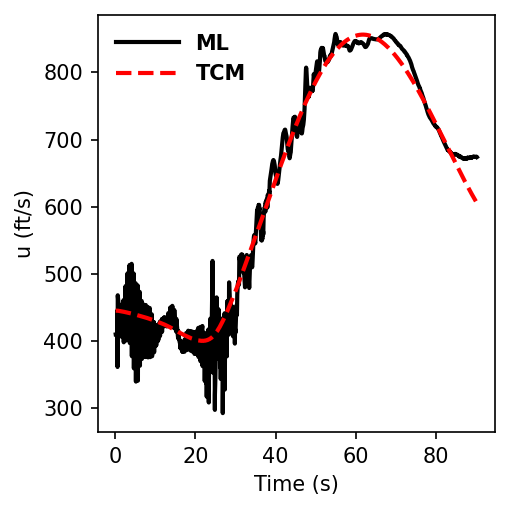

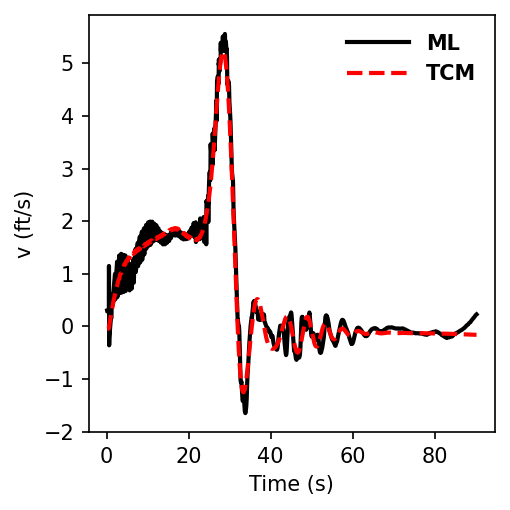

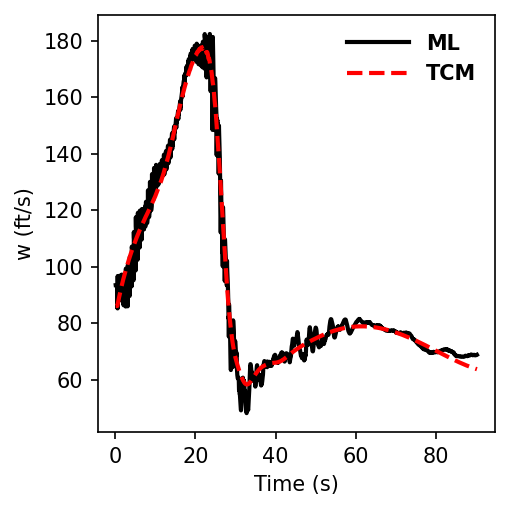

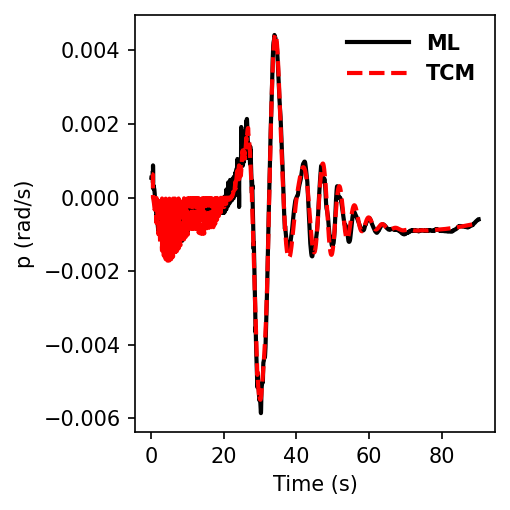

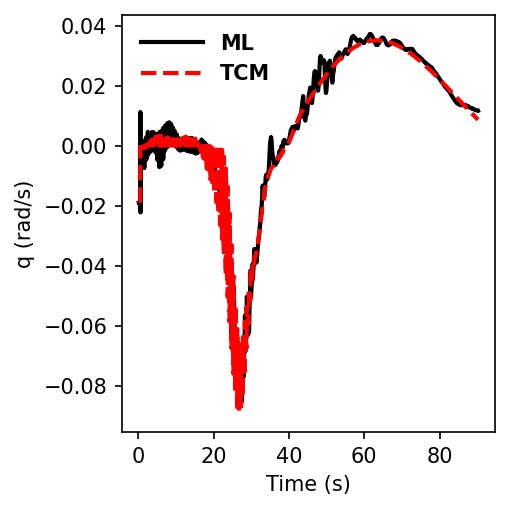

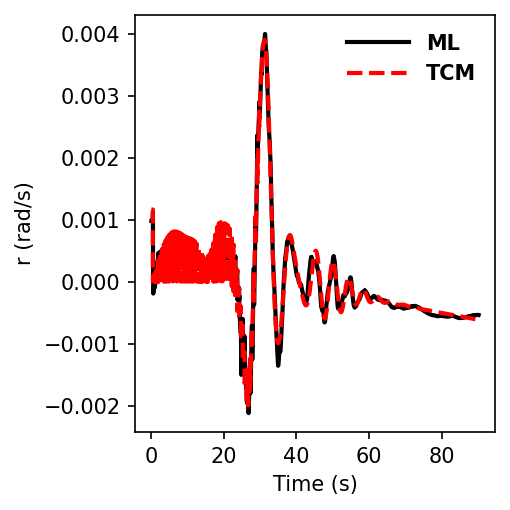

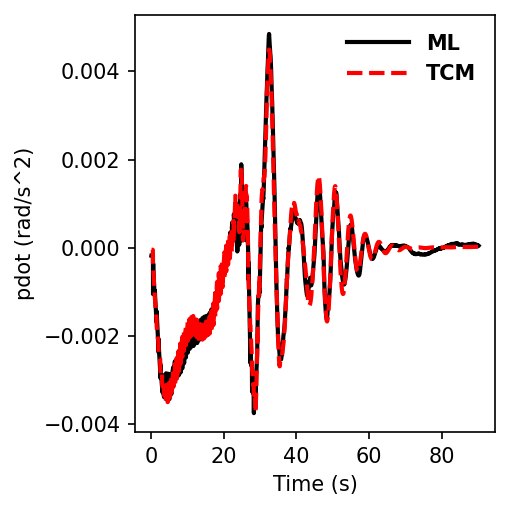

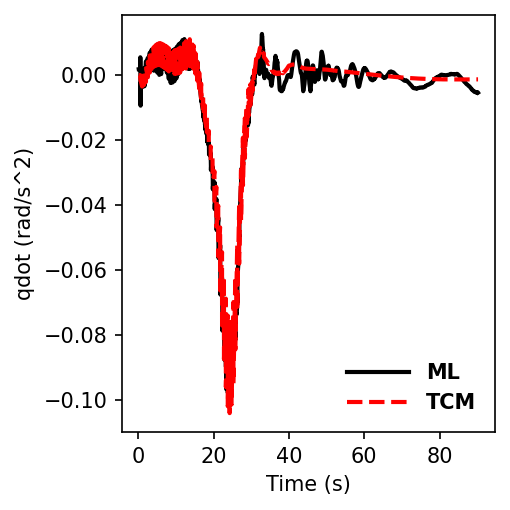

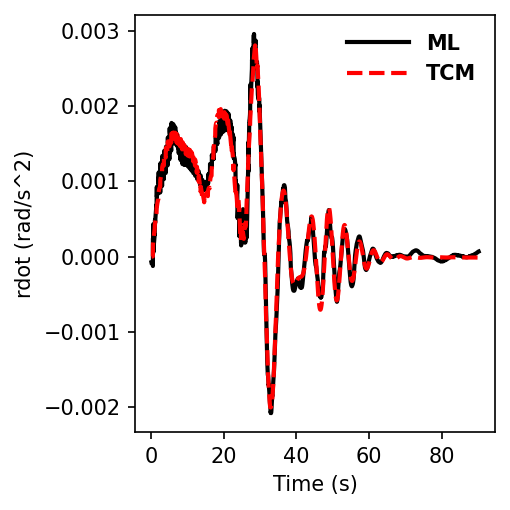

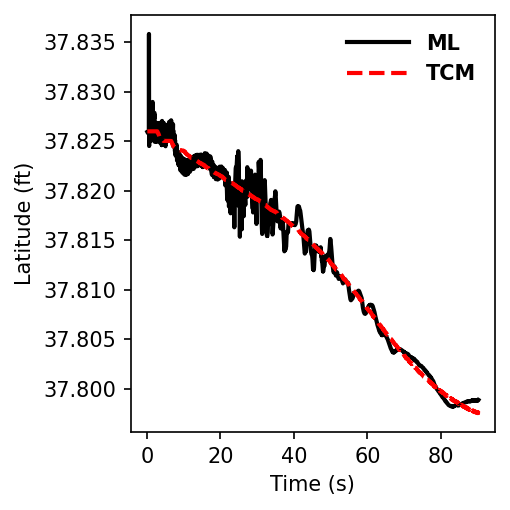

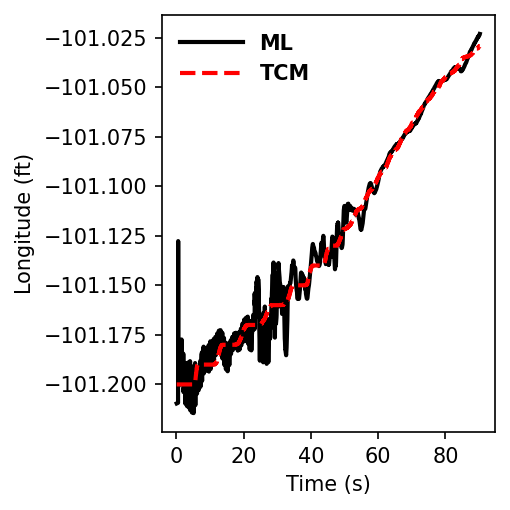

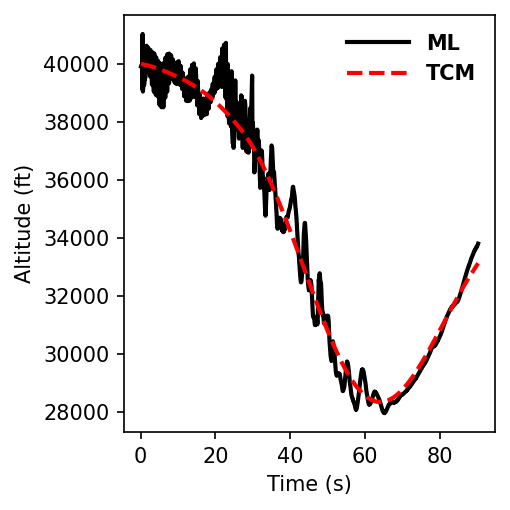

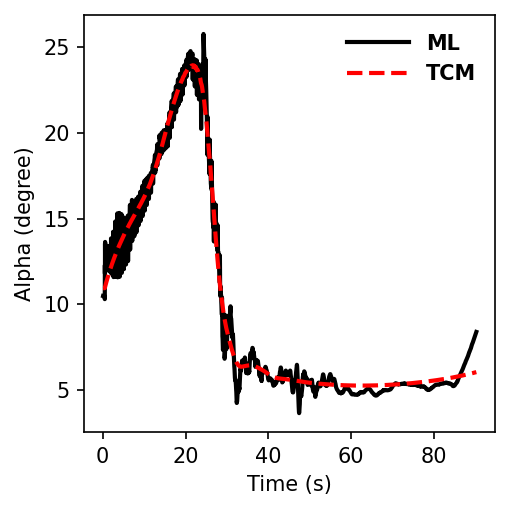

In [75]:
from utils import plotResponse

plotResponse(predictedData,orignalData,scaled_Data.shape[0],InitialT,TotalTime,window_size,gtm_dt,outDir,notebook=True)